In [1]:
import os, sys, random, re, collections, string
import numpy as np
import torch
import math
import csv
import sklearn.model_selection
import sklearn.metrics
import heapq
import matplotlib
import tqdm
import transformers
import datasets
import sentence_transformers
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torch.optim import AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [20]:
true = np.random.randint(0, 2, (1, 100)).reshape(-1)
pred = np.random.randint(0, 2, (1, 100)).reshape(-1)
# pred = np.full((1, 100), 0).reshape(-1)

In [21]:
cm = confusion_matrix(true, pred)
cm

array([[35, 25],
       [19, 21]])

In [25]:
print(f"""acc: {accuracy_score(true, pred):.3f}, f1: {f1_score(true, pred, average="macro"):.3f}
Yes: prec: {precision_score(true, pred, pos_label=1, zero_division=0):.3f}, recall: {recall_score(true, pred, pos_label=1, zero_division=0):.3f}, f1: {f1_score(true, pred, pos_label=1, zero_division=0):.3f}
No: prec: {precision_score(true, pred, pos_label=0, zero_division=0):.3f}, recall: {recall_score(true, pred, pos_label=0, zero_division=0):.3f}, f1: {f1_score(true, pred, pos_label=0, zero_division=0):.3f}
""")

acc: 0.560, f1: 0.551
Yes: prec: 0.457, recall: 0.525, f1: 0.488
No: prec: 0.648, recall: 0.583, f1: 0.614



In [26]:
input = torch.randn(1, 500, 100)
target = torch.randint(0, 500, (1, 100))
F.cross_entropy(input, target)

tensor(6.7092)

In [9]:

# Parts I and II
boolq_dataset = load_dataset('google/boolq')

boolq_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})

In [10]:
val_labels = [1 if x["answer"] else 0 for x in boolq_dataset["validation"]]

In [11]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelForCausalLM
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
# model = GPT2LMHeadModel.from_pretrained('distilgpt2').cuda()
# model = AutoModelForCausalLM.from_pretrained('distilgpt2').cuda()

In [16]:
tokenizer.encode("yes")[0], tokenizer.encode("no"), tokenizer.encode(" yes"), tokenizer.encode(" no")

(8505, [3919], [3763], [645])

In [13]:

def boolq2tensor(x, append_answer=False):
    if append_answer:
        return tokenizer.encode(f"{x['passage']}.\n{x['question']}?\n{'yes' if x['answer'] else 'no'}", return_tensors="pt")
    else:
        return tokenizer.encode(f"{x['passage']}.\n{x['question']}?\n", return_tensors="pt")
# List is alright here for the moment since max token length is 1024 and the max in the dataset is 25
val_set = [boolq2tensor(x) for x in boolq_dataset["validation"]]
train_set = [boolq2tensor(x, append_answer=True) for x in boolq_dataset["train"]]

In [16]:
val_len = pd.Series(val_set).apply(lambda x: x.shape[1])
train_len = pd.Series(train_set).apply(lambda x: x.shape[1])

<Axes: >

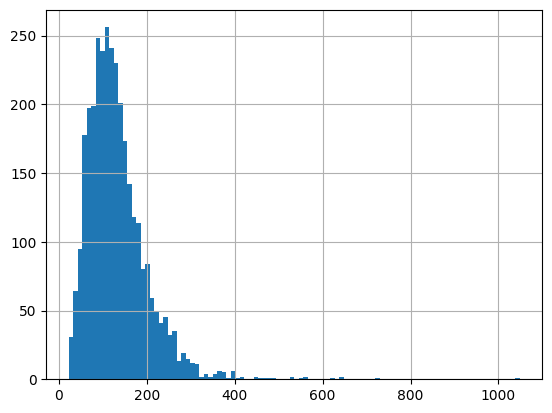

In [ ]:
val_len.hist(bins=100)



<Axes: >

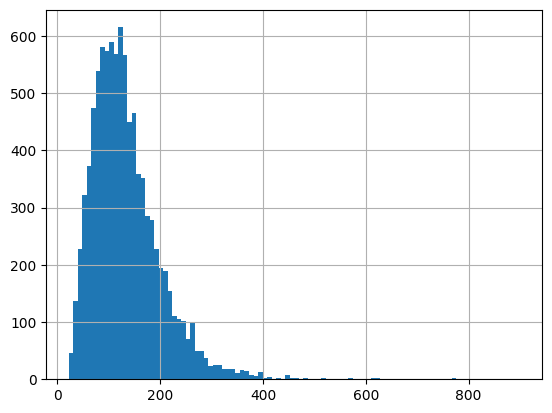

In [19]:
train_len.hist(bins=100)

In [13]:
def tensorlist2padded(tensorlist, length: int, pad_token_id: int, pad_strategy: str):
    assert len(tensorlist) > 0
    assert all(x.ndim == 2 for x in tensorlist)
    assert all(x.shape[0] == 1 for x in tensorlist)
    assert length > 0
    assert pad_token_id is not None
    assert pad_strategy in {"left", "right"}

    for i, x in enumerate(tensorlist):
        if x.shape[1] < length:
            if pad_strategy == "left":
                tensorlist[i] = torch.cat([torch.full((1, length - x.shape[1]), pad_token_id), x], dim=1)
            else:
                tensorlist[i] = torch.cat([x, torch.full((1, length - x.shape[1]), pad_token_id)], dim=1)
        elif x.shape[1] > length:
            if pad_strategy == "left":
                tensorlist[i] = x[:, -length:]
            else:
                tensorlist[i] = x[:, :length]
        else:
            assert x.shape[1] == length

    concat_tensor = torch.cat(tensorlist, dim=0)
    return concat_tensor

# val_tensor = tensorlist2padded(val_set, 200, tokenizer.unk_token_id, "left").cuda()
# train_tensor = tensorlist2padded(train_set, 1024, tokenizer.unk_token_id, "left").cuda()


In [14]:
# train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_tensor, batch_size=16, shuffle=False)


In [20]:
labels_pred = []
# for x in val_set:
for x in tqdm.tqdm(val_set):
    with torch.no_grad():
        if x.shape[1] > 1024:
            x = x[:, -1024:]
        out = model(x.cuda()).logits
        # labels_pred.extend(out[:, -1, [645, 3763]].argmax(dim=1).cpu().tolist())
        labels_pred.extend(out[:, -1, [3919, 8505]].argmax(dim=1).cpu().tolist())

# tokenizer.decode(out[:, -1, :].argmax(dim=1))

100%|██████████| 3270/3270 [00:07<00:00, 413.97it/s]


In [21]:
# labels_pred = []
# for x in val_loader:
#     with torch.no_grad():
#         out = model(x.cuda()).logits
#         labels_pred.extend(out[:, -1, [645, 3763]].argmax(dim=1).cpu().tolist())


In [22]:
labels = [1 if x['answer'] else 0 for x in boolq_dataset["validation"]]

In [23]:
from collections import Counter
Counter(labels_pred), Counter(labels)

(Counter({0: 2303, 1: 967}), Counter({1: 2033, 0: 1237}))

In [ ]:
# tokenizer.encode(["no", "yes"]) -> [3919, 8505]
output_stacked = torch.stack(outputs)[:, [645, 3763]]

In [45]:
labels = np.array([1 if x['answer'] else 0 for x in boolq_dataset["validation"]])

In [46]:
label_pred = output_stacked.argmax(dim=1)
label_pred = label_pred.cpu().numpy()

In [ ]:
print(f"""
Overall: acc: {accuracy_score(labels, label_pred):.3f}, f1: {f1_score(labels, label_pred):.3f}
    Yes: prec: {precision_score(labels, label_pred, pos_label=1):.3f}, recall: {recall_score(labels, label_pred, pos_label=1):.3f}, f1: {f1_score(labels, label_pred, pos_label=1):.3f}
     No: prec: {precision_score(labels, label_pred, pos_label=0):.3f}, recall: {recall_score(labels, label_pred, pos_label=0):.3f}, f1: {f1_score(labels, label_pred, pos_label=0):.3f}
""")

In [65]:
model = model.cpu()

In [66]:
torch.cuda.empty_cache()

In [ ]:
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

In [ ]:
def tensorlist2padded(tensorlist, length=32, pad_token=0):

In [ ]:
max([
    boolq2tensor(x).shape[1]
    for x in boolq_dataset["train"]
])

In [ ]:
boolq_dataset["train"]